### Initialization and Loading data

In [164]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

from xgboost import XGBClassifier
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("clean_data.csv").drop("Unnamed: 0", axis=1)
from pandas.api.types import is_object_dtype

# In some columns different caps lead to different categories
# So before assigning categories everything is lowercased
for col in data.columns:
    if col == "university" or col == "university_with_year":
        continue
    if is_object_dtype(data[col]):
        data[col] = data[col].str.lower()
        data[col] = data[col].astype('category')
        # data[col] = data[col].cat.codes + 1


data_features = data.drop(labels=["university_with_year", "score", "class", "rank_display_raw", "city", "country"], axis=1)
data_score = data["score"]
data_class = data["class"]

data_no_na = data.dropna()
data_features_no_na = data_no_na.drop(labels=["university_with_year", "score", "class", "rank_display_raw", "city", "country"], axis=1)
data_score_no_na = data_no_na["score"]
data_class_no_na = data_no_na["class"]

data_features = pd.get_dummies(data_features)
data_features_no_na = pd.get_dummies(data_features_no_na)
data_features.drop(labels=["type_public"], axis=1, inplace=True)
data_features_no_na.drop(labels=["type_public"], axis=1, inplace=True)

#### Useful functions

In [165]:
def get_training_sets(features, target, test_size=0.2):
    return train_test_split(
        features,
        target,
        test_size=test_size
    )


def get_Nth_best_features_df(names, importance, N=15):
    best_indexes = np.argpartition(np.abs(importance), -N)[-N:]

    return pd.DataFrame({
        "Feature": names[best_indexes],
        "Importance": importance[best_indexes]
    })
    


def clf_score(model, test_x, test_y):

    pred_y = model.predict(test_x).astype(int)

    d = {
        "accuracy": metrics.accuracy_score,
        "precision": lambda true, pred: metrics.precision_score(true, pred, average="macro"),
        "recall": lambda true, pred: metrics.recall_score(true, pred, average="macro"),
        "jaccard": lambda true, pred: metrics.jaccard_score(true, pred, average="macro"),
    }

    return {
        name: method(test_y, pred_y)
        for name, method in d.items()
    }


def reg_score(model, test_x, test_y):

    pred_y = model.predict(test_x)

    d = {
        "explained variance": metrics.explained_variance_score,
        "RMSE": metrics.mean_squared_error,
        "R2": metrics.r2_score
    }

    return {
        name: method(test_y, pred_y)
        for name, method in d.items()
    }

### Decision Tree

#### Tree Classification

Scores:
  Accuracy: 0.62
  Precision: 0.58
  Recall: 0.57
  Jaccard: 0.44


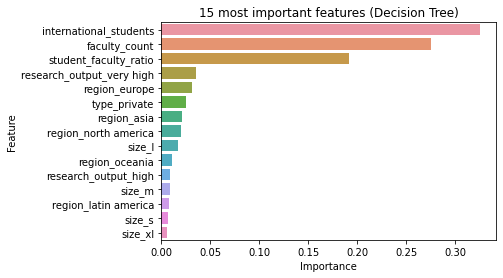

In [166]:


def show_tree_results(model, test_x, test_y, with_graph=True):
    # Scores
    scores = clf_score(model, test_x, test_y)
    print("Scores:")
    print("\n".join([
        f"  {name.capitalize()}: {score:0.2f}"
        for name, score in scores.items()
    ]))

    # Features importance
    N = 15
    best_features = get_Nth_best_features_df(model.feature_names_in_, model.feature_importances_, N)

    sns.barplot(
        x="Importance", y="Feature",
        data=best_features,
        order=best_features.sort_values("Importance", ascending=False).Feature
    )
    plt.title(f"{N} most important features (Decision Tree)")
    plt.show()

    # Graph
    if with_graph:
        plt.figure(figsize=(20, 20))
        tree.plot_tree(model, fontsize=6)
        plt.savefig('tree_results', dpi=100)
        

def decision_tree():

    train_x, test_x, train_y, test_y = get_training_sets(data_features, data_class)
    
    # Training
    tree_clf = tree.DecisionTreeClassifier()
    tree_clf.fit(train_x, train_y)
    
    # Results
    show_tree_results(tree_clf, test_x, test_y, with_graph=False)
    
decision_tree()

### Regression

#### Linear Model

Scores:
Classification:
  Accuracy: 0.18
  Precision: 0.15
  Recall: 0.10
  Jaccard: 0.05
Regression:
  Explained variance: 0.49
  Rmse: 4.78
  R2: 0.49


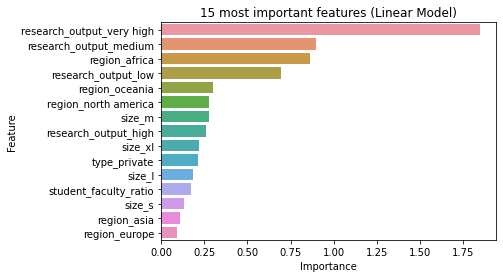

In [167]:
def show_lm_results(model, test_x, test_y):
    # Scores
    reg_scores = reg_score(model, test_x, test_y)
    clf_scores = clf_score(model, test_x, test_y)

    print("Scores:")
    
    print("Classification:")
    print("\n".join([
        f"  {name.capitalize()}: {score:0.2f}"
        for name, score in clf_scores.items()
    ]))

    print("Regression:")
    print("\n".join([
        f"  {name.capitalize()}: {score:0.2f}"
        for name, score in reg_scores.items()
    ]))

    # Features importance
    N = 15
    best_features = get_Nth_best_features_df(model.feature_names_in_, model.coef_, N)

    sns.barplot(
        x="Importance", y="Feature",
        data=best_features,
        order=best_features.sort_values("Importance", ascending=False).Feature
    )
    plt.title(f"{N} most important features (Linear Model)")
    plt.show()


scored_data = data.dropna()

def linear_model():
    train_x, test_x, train_y, test_y = get_training_sets(data_features, data_class)

    # Training
    lm_clf = LinearRegression()
    lm_clf.fit(train_x, train_y)

    # Results
    show_lm_results(lm_clf, test_x, test_y)

linear_model()

### XGBoost

#### Régression

Scores:
  Explained variance: 0.94
  Rmse: 23.93
  R2: 0.94


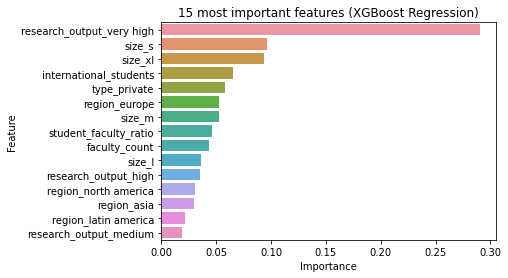

In [168]:
def show_score_xgreg_results(model, test_x, test_y, features_names):
    # Scores
    reg_scores = reg_score(model, test_x, test_y)

    print("Scores:")
    print("\n".join([
        f"  {name.capitalize()}: {score:0.2f}"
        for name, score in reg_scores.items()
    ]))

    # Features importance
    N = 15
    best_features = get_Nth_best_features_df(features_names, model.feature_importances_, N)

    sns.barplot(
        x="Importance", y="Feature",
        data=best_features,
        order=best_features.sort_values("Importance", ascending=False).Feature
    )
    plt.title(f"{N} most important features (XGBoost Regression)")
    plt.show()

    
def score_xgregression():
    # not_feature_cols = [
    #     "university_with_year", "rank_display",
    #     "rank_display_raw", "class"
    # ]

    # xgreg_data = data.drop(labels=not_feature_cols, axis=1)
    # xgreg_data.dropna(inplace=True)
    # xgreg_data_features = data_features.dropna()
    # xgreg_data_score = data_features.dropna()

    train_x, test_x, train_y, test_y = get_training_sets(data_features_no_na, data_score_no_na)

    # Training
    xg_clf = XGBRegressor()
    xg_clf.fit(train_x, train_y)

    # Score
    show_score_xgreg_results(xg_clf, test_x, test_y, data_features_no_na.columns)

score_xgregression()
    
    

#### Classification

[20:30:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores:
  Accuracy: 0.61
  Precision: 0.57
  Recall: 0.57
  Jaccard: 0.44


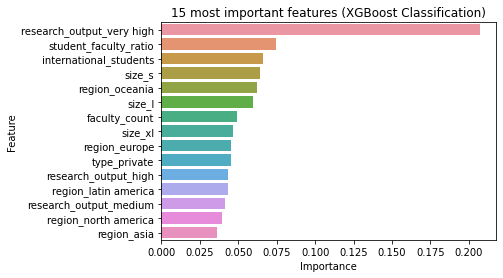

In [169]:
def show_rank_xgclf_results(model, test_x, test_y, features_names):
    # Scores
    clf_scores = clf_score(model, test_x, test_y)

    print("Scores:")
    print("\n".join([
        f"  {name.capitalize()}: {score:0.2f}"
        for name, score in clf_scores.items()
    ]))

    # Features importance
    N = 15
    best_features = get_Nth_best_features_df(features_names, model.feature_importances_, N)

    sns.barplot(
        x="Importance", y="Feature",
        data=best_features,
        order=best_features.sort_values("Importance", ascending=False).Feature
    )
    plt.title(f"{N} most important features (XGBoost Classification)")
    plt.show()
    

def rank_xgclassification():
    train_x, test_x, train_y, test_y = get_training_sets(data_features, data_class)

    # Training
    xg_clf = XGBClassifier()
    xg_clf.fit(train_x, train_y)

    # Score
    show_rank_xgclf_results(xg_clf, test_x, test_y, data_features.columns)

rank_xgclassification()
    
    